# CHAPTER 2

## BPE tokenizer

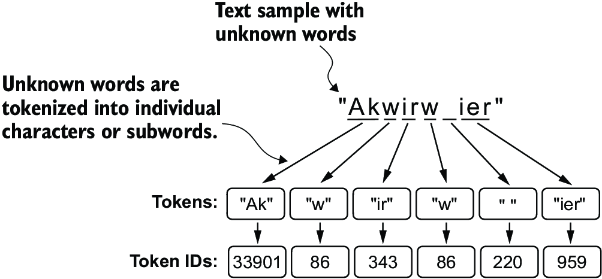

In [ ]:
pip install tiktoken

In [ ]:
from importlib.metadata import version
import tiktoken
print("tiktoken version: ", version("tiktoken"))

tiktoken version:  0.9.0


In [ ]:
BPE_tokenizer = tiktoken.get_encoding("gpt2")
text = "Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunknownPlace."
tokens = BPE_tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print(tokens)



[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 286, 617, 34680, 27271, 13]


In [ ]:
decode_text = BPE_tokenizer.decode(tokens)
print(decode_text)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunknownPlace.


In [ ]:
unknow_word = "Akwirw ier"
encode_nums = BPE_tokenizer.encode(unknow_word)
for num in encode_nums:
    print(f"{num}: {BPE_tokenizer.decode([num])}")

33901: Ak
86: w
343: ir
86: w
220:  
959: ier


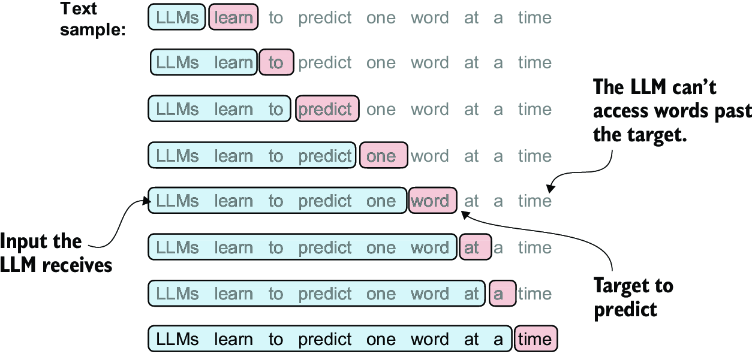

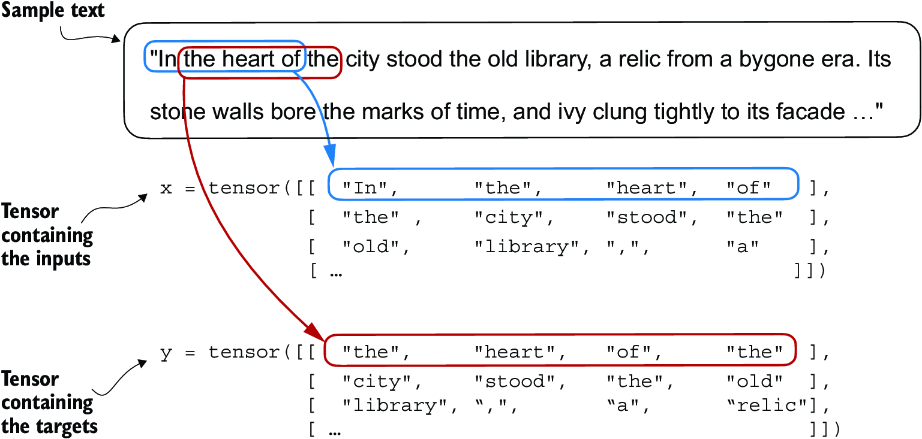

In [ ]:
import torch
from torch.utils.data import DataLoader,Dataset


In [ ]:
class GPTdatasetV1(Dataset):

    """
    Dataset for GPT-2, Slide Window.
    txt: Input text.
    tokenizer: Tokenizer.
    window_length: Length of the window.
    stride: Stride of the window. (How many words to skip).

    __len__: return size of the input data.
    """

    def __init__(self, txt, tokenizer, window_length, stride):
        self.input_ids = []
        self.output_ids = []

        words_to_nums = tokenizer.encode(txt)

        for i in range(0, len(words_to_nums) - window_length, stride):
            self.input_ids.append(torch.tensor(words_to_nums[i:i+window_length]))
            self.output_ids.append(torch.tensor(words_to_nums[i+1:i+window_length+1]))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.output_ids[idx]


In [ ]:
# Customize dataloader

def create_dataloader_v1(txt, batch_size=4, window_length=256, stride=128,shuffle=True, drop_last=True, num_workers=0):
    # define tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # define dataset
    dataset = GPTdatasetV1(txt, tokenizer, window_length, stride)

    # define dataloader
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader

In [ ]:
with open("the-verdict.txt", "r") as fn:
    raw_txt = fn.read()

dataloader = create_dataloader_v1(raw_txt, 1, 4, 1, False)
iter_dataloader = iter(dataloader)
first = next(iter_dataloader)
first

[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]

## Token Embedding

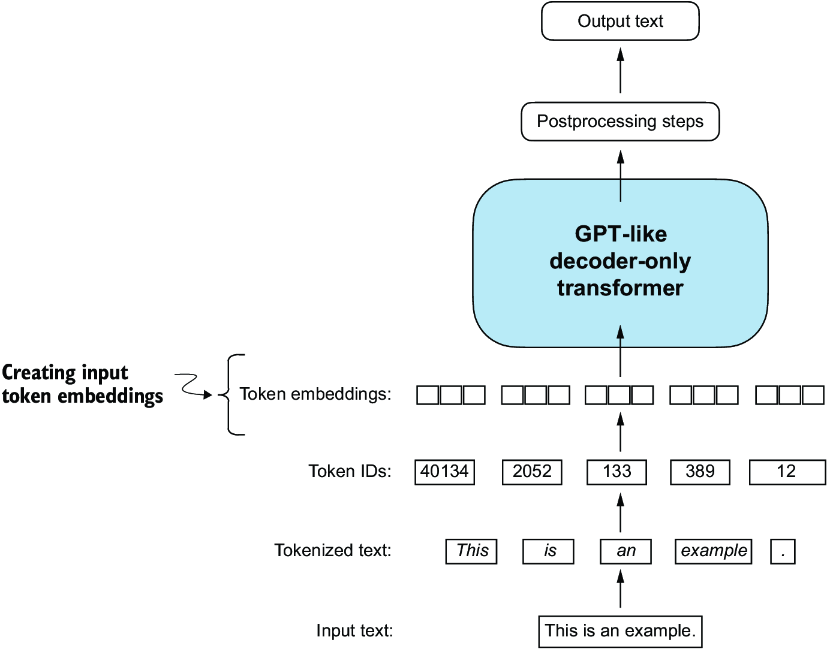

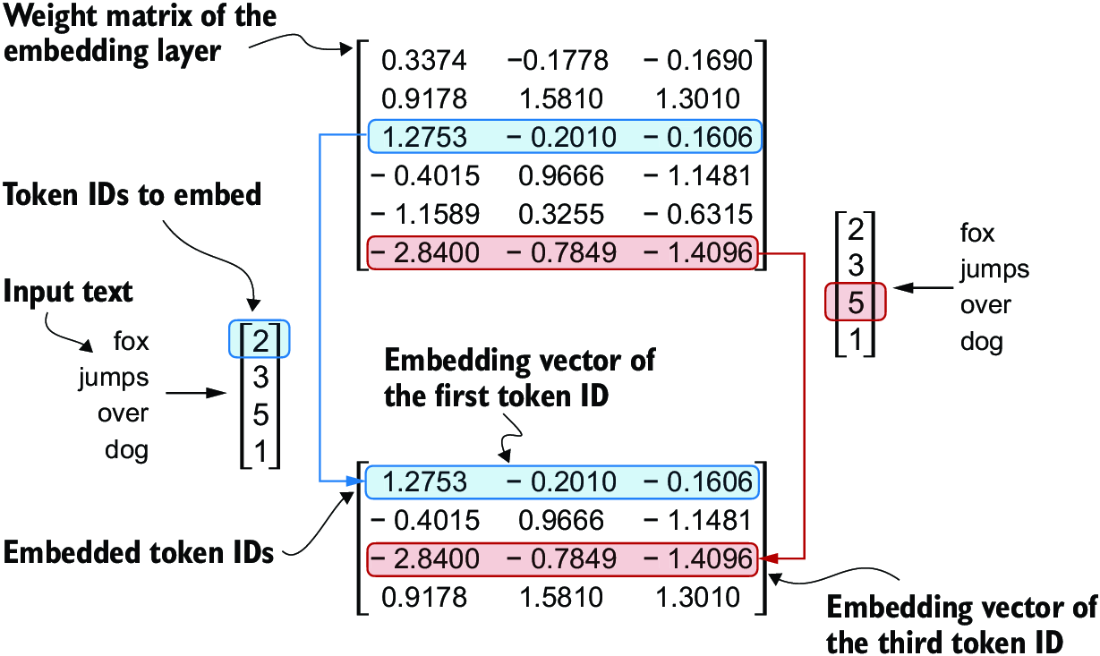

##Encoding word positions

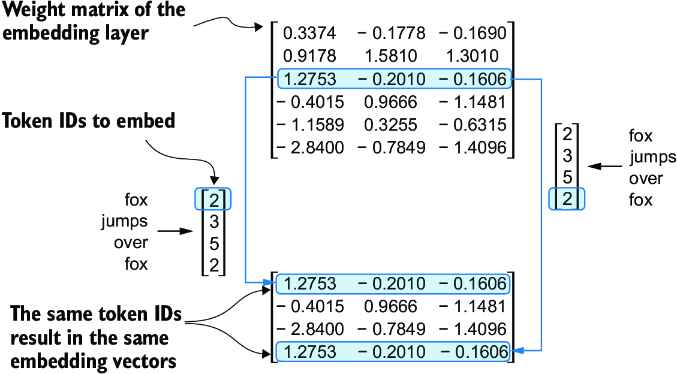

The way the previously introduced embedding layer works is that the same token ID always gets mapped to the same vector representation, regardless of where the token ID is positioned in the input sequence.The embedding layer converts a token ID into the same vector representation regardless of where it is located in the input sequence. For example, the token ID 5, whether it’s in the first or fourth position in the token ID input vector, will result in the same embedding vector.

since the self-attention mechanism of LLMs itself is also position-agnostic, it is helpful to inject additional position information into the LLM.

##Absolute positional embeddings

are directly associated with specific positions in a sequence. For each position in the input sequence, a unique embedding is added to the token’s embedding to convey its exact location. For instance, the first token will have a specific positional embedding, the second token another distinct embedding, and so on.

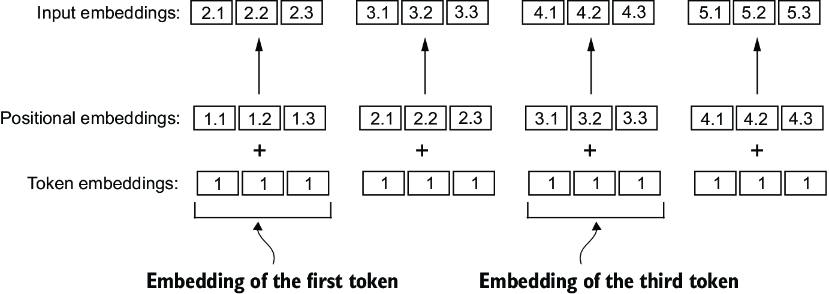

Positional embeddings are added to the token embedding vector to create the input embeddings for an LLM. The positional vectors have the same dimension as the original token embeddings. The token embeddings are shown with value 1 for simplicity.

## Relative positional embeddings

is on the relative position or distance between tokens. This means the model learns the relationships in terms of “how far apart” rather than “at which exact position.” The advantage here is that the model can generalize better to sequences of varying lengths, even if it hasn’t seen such lengths during training.

In [ ]:
vocab_size = 50257
output_dim = 256
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
token_embedding_layer

Embedding(50257, 256)

In [ ]:
# Batch size of 8 with 4 tokens each, 8 * 4 * 256

window_length = 4
dataloader = create_dataloader_v1(raw_text, 8, window_length, window_length, shuffle=False)
dataloader_iter = iter(dataloader)
inputs, outputs = next(dataloader_iter)
inputs.shape
# 8 words input , 4 for each word

NameError: name 'raw_text' is not defined

In [ ]:
token_embedding = token_embedding_layer(inputs)
token_embedding.shape

In [ ]:
# words
#-> create a Class  (tensor dataset) return [1. input words ids, 2. predict the next words ids] with encoder your choosed
#-> create dataloader with tiktoken encoder.return a tensor dataloader, [input, output(predict next word id)]
#-> use torch.nn.Embedding(datasize, output_dim) create a position matrix
#-> take the input from tensor dataloader apply to position matrix

For a GPT model’s absolute embedding approach, we just need to create another embedding layer that has the same embedding dimension as the token_embedding_ layer:

In [ ]:
context_length = max_length = 4
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)
pos_embeddings = pos_embedding_layer(torch.arange(context_length))
print(pos_embeddings.shape)
pos_embeddings
# Note: layer is changeable even adopted to other layers
# pos_embedding_layer [changeable] -> torch.arange layer [static]

torch.Size([4, 256])


tensor([[ 0.8450,  0.3346, -0.2839,  ..., -0.7630, -0.1970, -0.6766],
        [-1.2667,  1.5775,  0.0668,  ...,  0.6369,  0.3437,  0.2013],
        [-0.4622, -0.7602,  0.1509,  ...,  1.5171, -0.4035,  0.9082],
        [ 0.5371,  0.2798, -0.7757,  ..., -1.5672,  0.8650, -0.1098]],
       grad_fn=<EmbeddingBackward0>)

**torch.nn.Embedding(context_length, output_dim)**

Creates a learnable lookup table (i.e. embedding matrix) of shape [context_length, output_dim].

Each index i from 0 to context_length - 1 maps to a vector of size output_dim.

**torch.arange(context_length)**

Generates the sequence [0, 1, 2, ..., context_length - 1]. These are the absolute positions in the input sequence.

**pos_embedding_layer(...)**

Looks up the embedding for each absolute position index.

So position 0 always maps to the same vector, position 1 to another, and so on.

Result shape: [context_length, output_dim]

One embedding vector per absolute position.

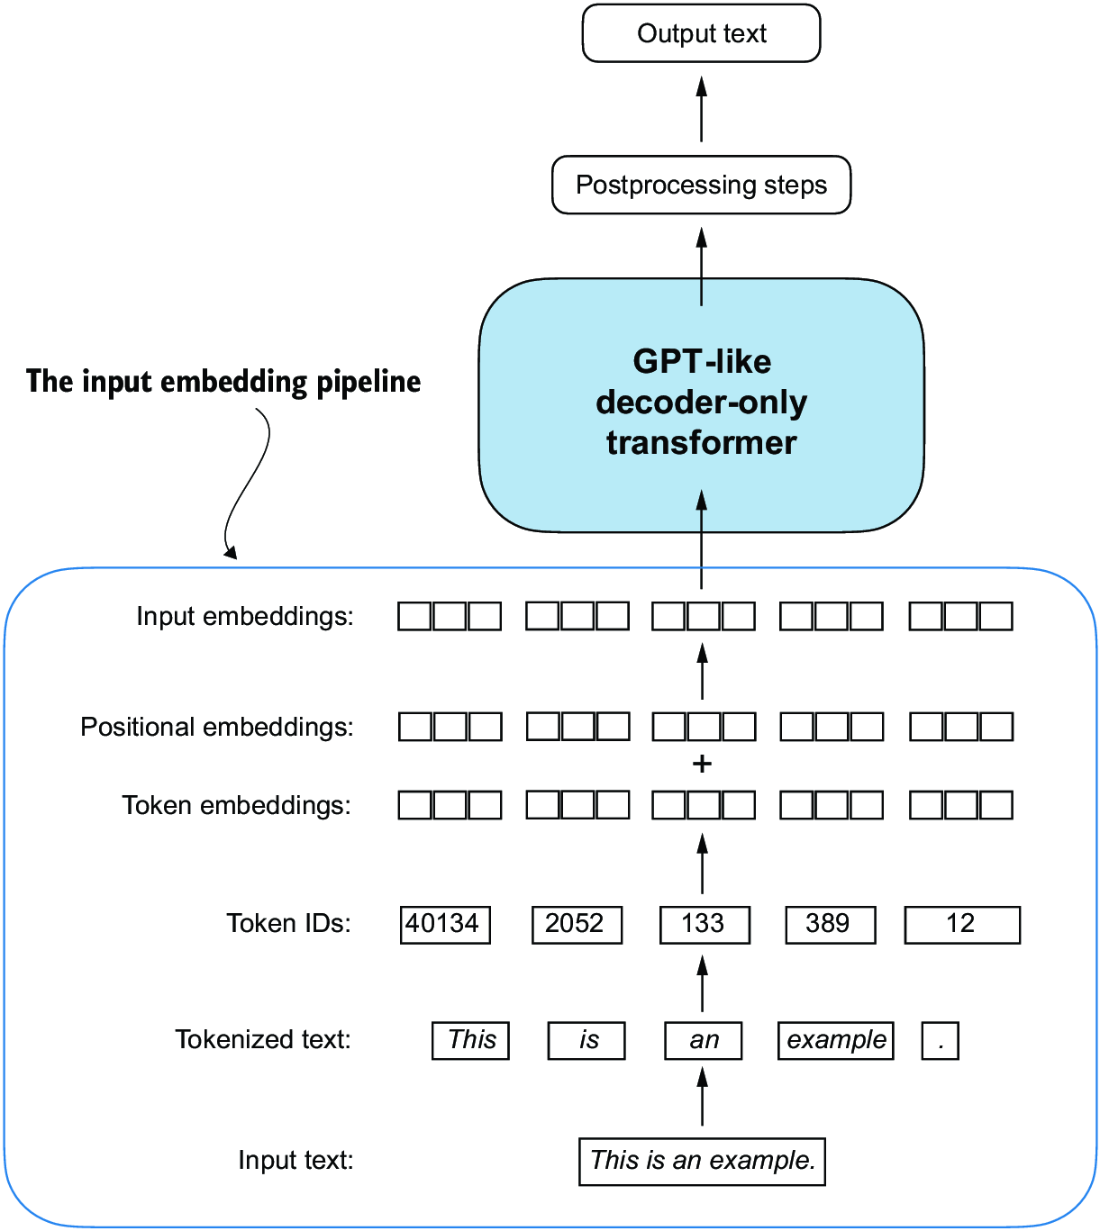

## SUMMARY

1. Raw text is broken into tokens, [words or charactors]
2. Tokens into integers -- token IDs
3. Handle special tokens: <|unk|> and <|endoftext|>
4. => BPE tokenizer -- tiktoken.get_encoding("gpt2")
5. Sliding window approach on tokenized data, input <-> predicted next word
6. Embedding layers in PyTorch function as a lookup operation, retrieving vectors corresponding to token IDs.
7. OpenAI’s GPT models utilize absolute positional embeddings, which are added to the token embedding vectors and are optimized during the model training.

## Start Token Embedding

In [ ]:
pip install tiktoken

In [ ]:
# 4. => BPE tokenizer -- tiktoken.get_encoding("gpt2")
import tiktoken
raw_text = "At this point, you know how to prepare the input text for training LLMs by splitting text into individual word and subword tokens, which can be encoded into vector representations, embeddings, for the LLM."
BPE_tokenizer_v1 = tiktoken.get_encoding("gpt2")
txt_encoding = BPE_tokenizer_v1.encode(raw_text)
txt_encoding[:5]

[2953, 428, 966, 11, 345]

In [ ]:
#5. Sliding window approach on tokenized data, input <-> predicted next word

import torch
from torch.utils.data import Dataset, DataLoader

class GPT_Dataset(Dataset):
  def __init__(self, txt, tokenizer, window_size, steps):
    self.input_ids = []
    self.output_ids = []

    word_nums = tokenizer.encode(txt)
    for i in range(0, len(word_nums) - window_size, steps):
      tensor_input = torch.tensor(word_nums[i : i + window_size])
      tensor_output = torch.tensor(word_nums[i + 1 : i + window_size + 1])
      self.input_ids.append(tensor_input)
      self.output_ids.append(tensor_output)

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.output_ids[idx]



In [ ]:
#Embedding layers in PyTorch function as a lookup operation, retrieving vectors corresponding to token IDs
def customize_dataloader(txt, batch_size=4, window_size=256, steps=128, shuffle=True, drop_last=True, num_workers=0):
  tokenizer = tiktoken.get_encoding("gpt2")
  dataset = GPT_Dataset(txt, tokenizer, window_size, steps)
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)
  return dataloader

with open("the-verdict.txt", "r") as fn:
    raw_txt = fn.read()

window_size = 4
dataloader = customize_dataloader(raw_text, 8, window_size, window_size, shuffle=False)
inputs, outputs = next(iter(dataloader))
inputs.shape


torch.Size([8, 4])

In [ ]:
# OpenAI’s GPT models utilize absolute positional embeddings, which are added to the token embedding vectors and are optimized during the model training.

input_size = 50257
output_dim = 256
token_embedding_layer = torch.nn.Embedding(input_size, output_dim)
token_embedding = token_embedding_layer(inputs)
token_embedding.shape

torch.Size([8, 4, 256])

## Start Positional Embeddings

In [ ]:
context_length = windew_size = 4
position_embedding_layer = torch.nn.Embedding(context_length, output_dim)
position_embedding = position_embedding_layer(torch.arange(context_length))
position_embedding.shape

torch.Size([4, 256])

## Start Input Embedding

In [ ]:
input_embedding = token_embedding + position_embedding
input_embedding.shape

torch.Size([8, 4, 256])